# DATAML 2024-25: Pulse Shape Discrimination

## Introduction
This project focuses on discriminating between two types of scintillation signals, Li6 and Po, and analyzing a mixed dataset (Phys). The main tasks are:

1. Explore the datasets and identify discriminative features.
2. Build and evaluate classification models.
3. Quantify model uncertainty and manage signal contamination.
4. Classify signals in the Phys dataset.

### Methodology
- Start with basic feature-based classifiers.
- Progress to advanced CNNs, incorporating attention mechanisms.
- Control contamination and quantify uncertainty for real-world relevance.

### Directory Structure
- `/data/`: Contains datasets (`Li6.npz`, `Po.npz`, `Phys.npz`).
- `/utils/`: Contains reusable functions for data loading, training, and evaluation.
- `/models/`: Stores trained models and checkpoints.


## Dataset Exploration

### Objective
Explore the datasets to understand their structure and characteristics:
- Visualize waveforms from `Li6` and `Po` datasets.
- Compare basic statistics and features.
- Identify potential discriminative features for classification.


In [167]:
# Import necessary libraries
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data loading & feature extraction
from utils.data_loading import load_waveforms
from utils.features_extraction import extract_features_dataset

# Waveform analysis (stats & waveforms)
from utils.waveforms_analysis import (
    compute_statistics,
    plot_stat_distributions,
    compute_average_waveform,
    plot_overall_average_overlay,
    plot_random_waveforms,
    plot_average_waveforms_per_detector,
    plot_difference_waveforms_per_detector,
    plot_heatmap_avg_difference
)

# Features visualization
from utils.features_visualization import (
    plot_features_by_base_feature
)


### Loading the Data
We load the `Li6` and `Po` datasets and examine their structure.


In [103]:
# Load only 10% of the data for quick testing
Li6_waveforms = load_waveforms("data/Li6.npz", key="data_array", fraction=0.01)
Po_waveforms = load_waveforms("data/Po.npz", key="data_array", fraction=0.01)

print(f"Li6 shape: {Li6_waveforms.shape}, Po shape: {Po_waveforms.shape}")

# Display dataset shapes
print(f"Li6 dataset shape: {Li6_waveforms.shape} (samples, channels, timepoints)")
print(f"Po dataset shape: {Po_waveforms.shape} (samples, channels, timepoints)")

Li6 shape: (530, 4, 7756), Po shape: (522, 4, 7756)
Li6 dataset shape: (530, 4, 7756) (samples, channels, timepoints)
Po dataset shape: (522, 4, 7756) (samples, channels, timepoints)


### Random Waveform Visualization
Visualize a few random waveforms from the datasets to observe their structure and amplitude variations.


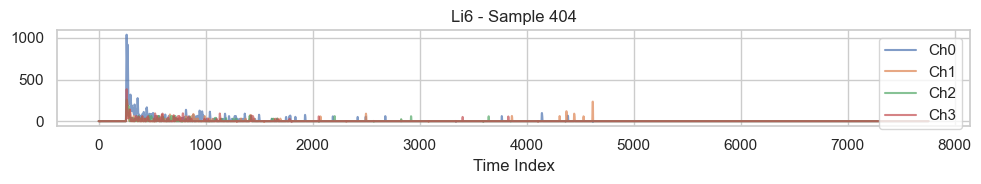

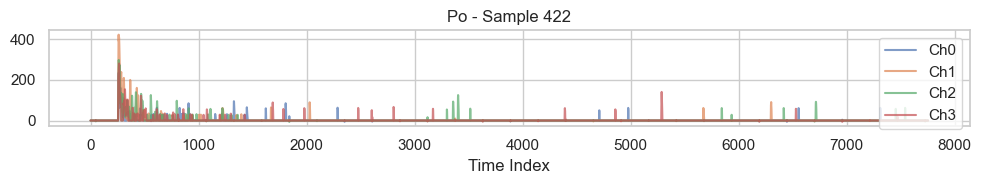

In [104]:
plot_random_waveforms(Li6_waveforms, dataset_name="Li6", num_samples=1)
plot_random_waveforms(Po_waveforms, dataset_name="Po", num_samples=1)


### Basic Statistics
We compute and visualize basic statistics for the `Li6` and `Po` datasets:
- Mean amplitude
- Maximum amplitude

These statistics help us understand the overall characteristics of the datasets.


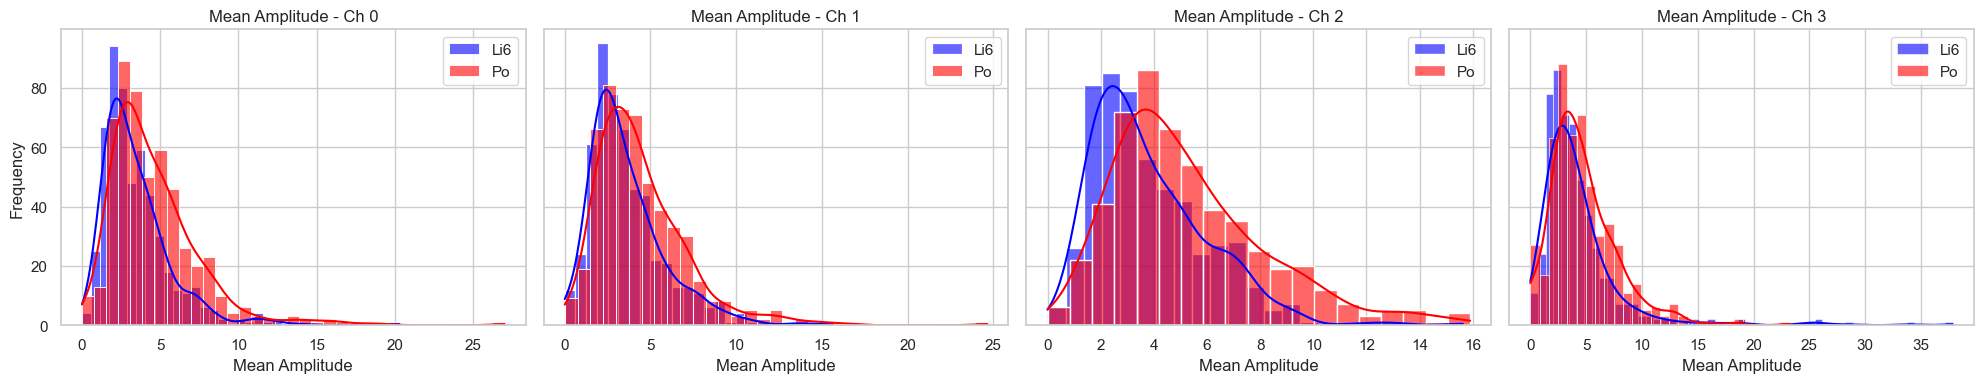

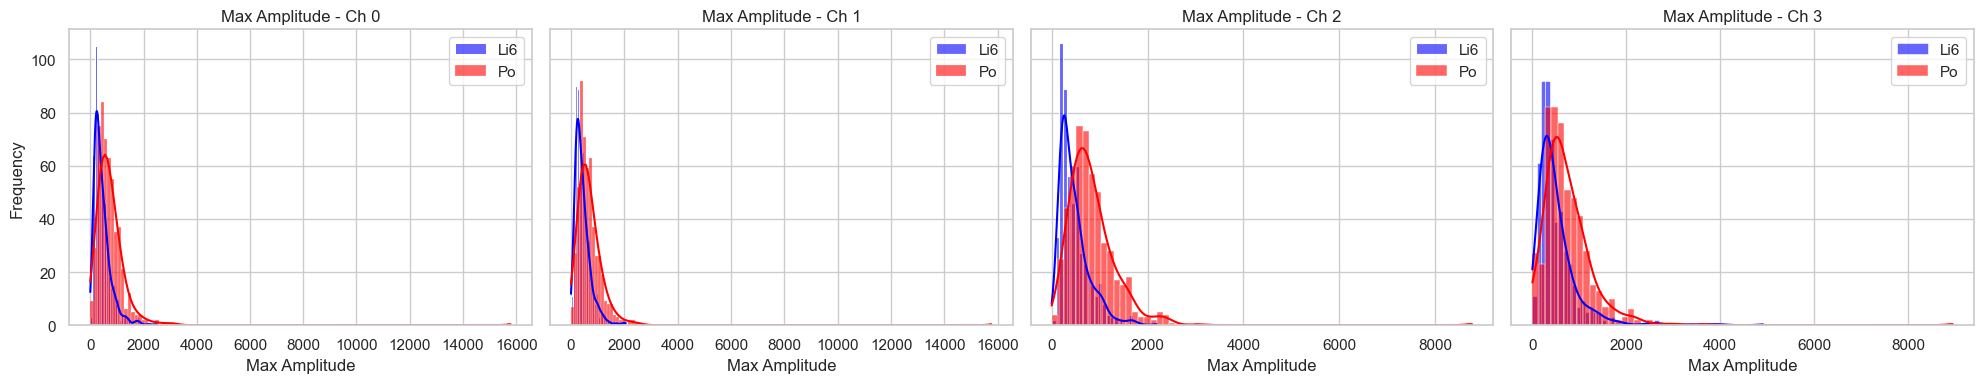

In [105]:
# Compute basic statistics for Li6 and Po datasets
Li6_stats = compute_statistics(Li6_waveforms)
Po_stats = compute_statistics(Po_waveforms)

# Plot distributions of Mean Amplitude
plot_stat_distributions(
    Li6_stats["mean"], Po_stats["mean"],
    stat_name="Mean Amplitude", dataset_names=("Li6", "Po")
)

# Plot distributions of Max Amplitude
plot_stat_distributions(
    Li6_stats["max"], Po_stats["max"],
    stat_name="Max Amplitude", dataset_names=("Li6", "Po")
)


### Average Waveform Comparison
We calculate the average waveform for the `Li6` and `Po` datasets and compare them:
- Individual channels
- Overall difference between datasets
These visualizations highlight general trends and differences between the datasets.


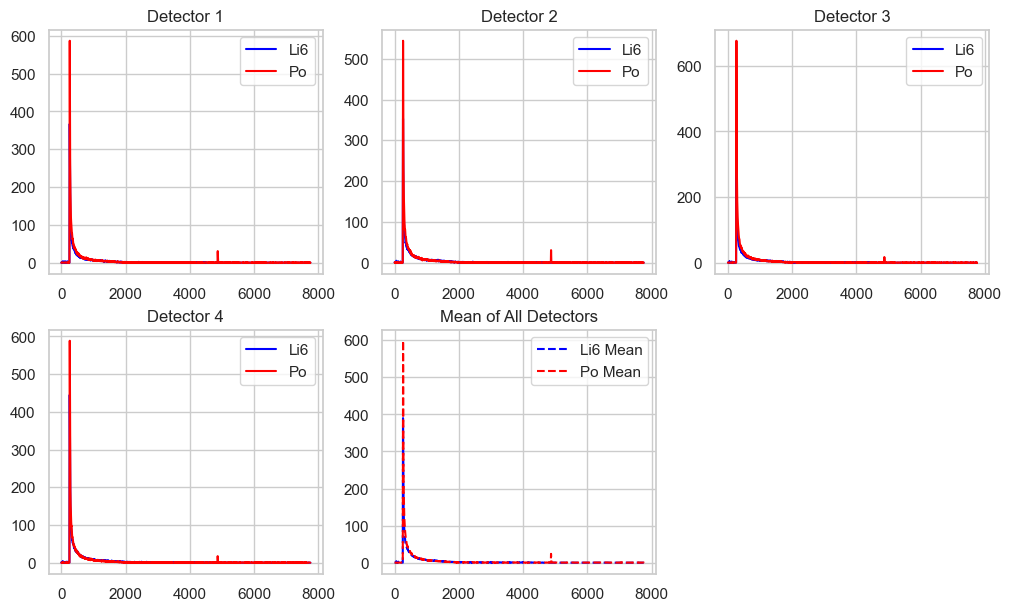

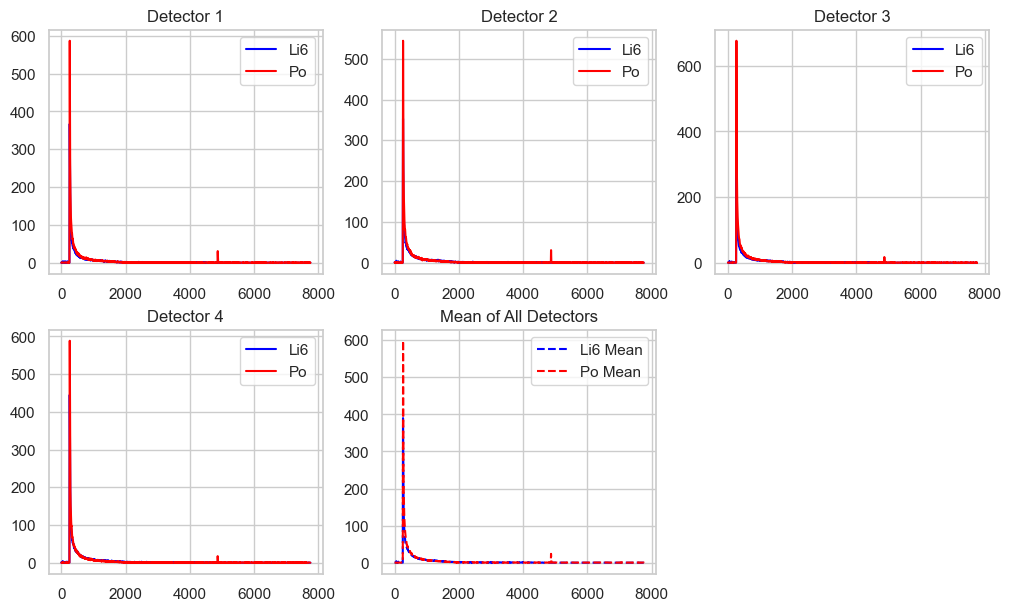

In [106]:
# Compute average waveforms for Li6 and Po datasets
avg_Li6 = compute_average_waveform(Li6_waveforms)
avg_Po = compute_average_waveform(Po_waveforms)

# Plot average waveforms per detector
plot_average_waveforms_per_detector(avg_Li6, avg_Po)

# Plot differences in average waveforms per detector
plot_difference_waveforms_per_detector(avg_Li6, avg_Po)


We can also create a 2D histogram to better visualize it 

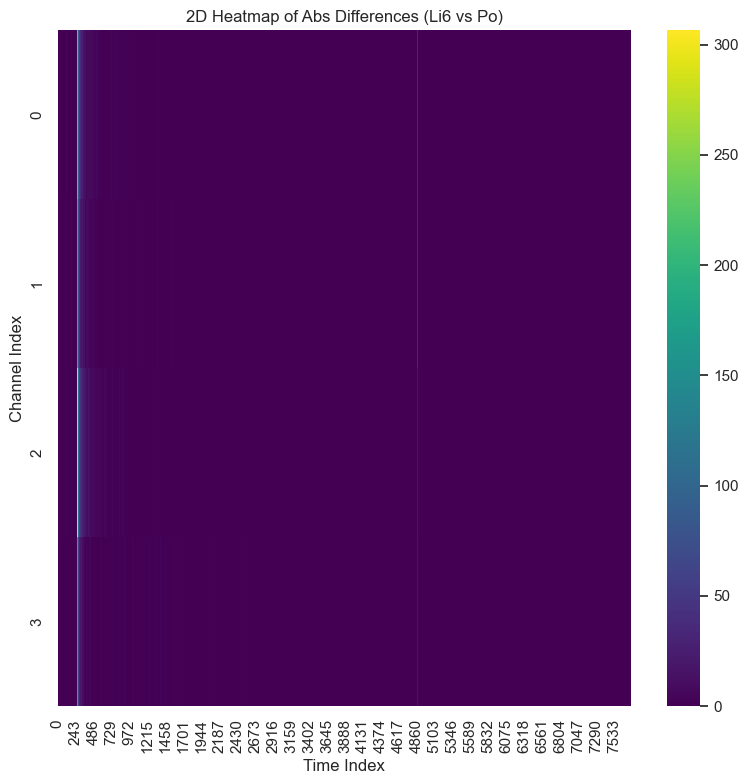

In [107]:
plot_heatmap_avg_difference(avg_Li6, avg_Po)


# Focused Analysis on Initial Time Indices
To better understand the differences in waveforms during the initial signal response, we focus our analysis on the first 800 time indices. This truncation allows us to examine the most significant region of the waveforms, which might provide clearer discriminative features.

We will:
- Truncate the average waveforms of `Li6` and `Po` datasets to only include the first 800 time indices.
- Visualize the truncated average waveforms for each detector.
- Analyze the difference between the truncated waveforms using a 2D histogram.


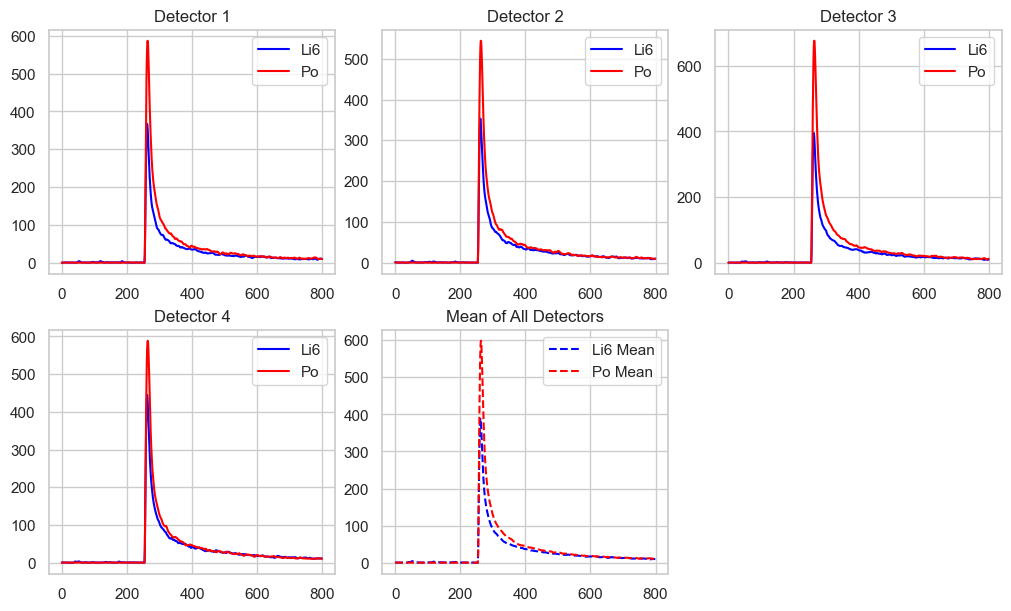

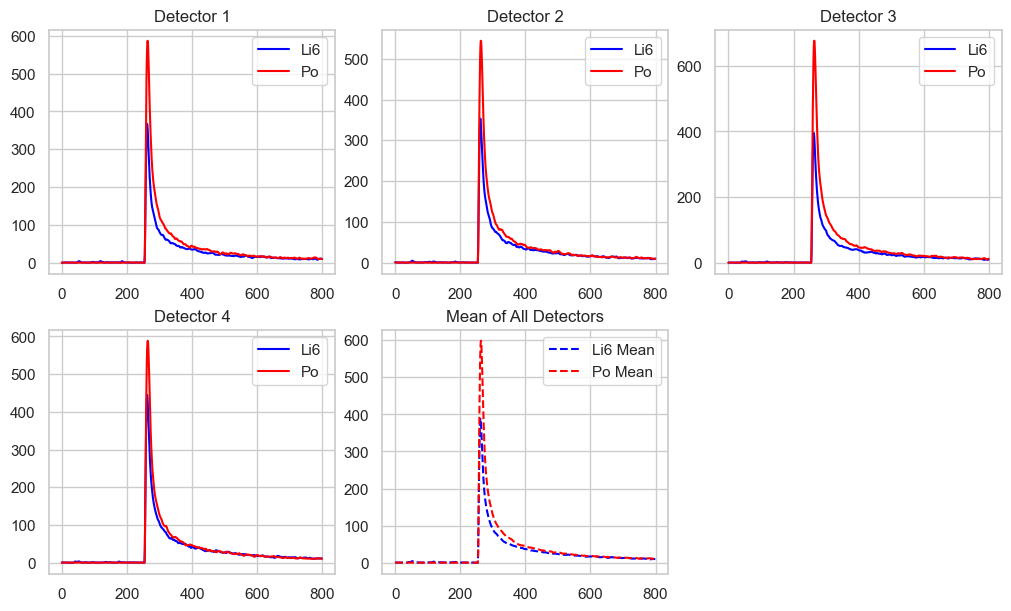

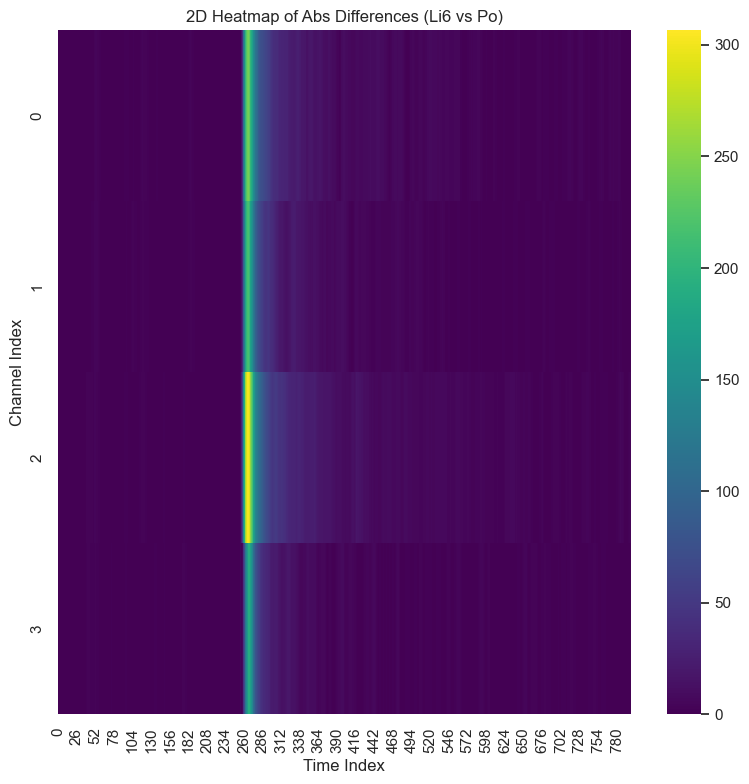

In [108]:
# Focus on the first 800 time indices
time_focus_start = 0
time_focus_end = 800

# Truncate average waveforms
avg_Li6_focus = avg_Li6[:, time_focus_start:time_focus_end]
avg_Po_focus = avg_Po[:, time_focus_start:time_focus_end]

# Plot truncated average waveforms
plot_average_waveforms_per_detector(avg_Li6_focus, avg_Po_focus)
plot_difference_waveforms_per_detector(avg_Li6_focus, avg_Po_focus)

# 2D histogram for the focused time indices
plot_heatmap_avg_difference(avg_Li6_focus, avg_Po_focus)


# Feature Extraction and Visualization
We compute four key characteristics for each signal in the dataset:
- Mean: Represents the average amplitude of the waveform.
- Peak: Captures the maximum amplitude of the waveform.
- Dominant Frequency: Indicates the most prominent frequency in the signal's spectrum.
- Spectral Entropy: Measures the randomness or complexity of the waveform's frequency distribution.

These features are extracted for all four channels, resulting in a total of 16 features per sample. Once extracted, we visualize their relationships using pair plots to identify potential discriminative patterns.


In [194]:
# Extract features for Li6 and Po datasets
feature_names = ["Mean", "Peak", "Dominant_Freq", "Spectral_Entropy"]
feature_names_full = [f"{name}_Ch{i}" for i in range(4) for name in feature_names]

# Example:  Suppose the real sampling rate is 10 kHz
Li6_features = extract_features_dataset(Li6_waveforms, sampling_rate=1000000.0)
Po_features  = extract_features_dataset(Po_waveforms, sampling_rate=1000000.0)


# Combine features and labels for pair plot
features = np.vstack([Li6_features, Po_features])
labels = np.concatenate([np.zeros(len(Li6_features)), np.ones(len(Po_features))])

# Generate pair plots with detailed annotations
selected_features = ["Mean_Ch0", "Peak_Ch1", "Dominant_Freq_Ch2", "Spectral_Entropy_Ch3"]

### Compare Extracted Features Across Detectors

We now switch the viewpoint: **instead of** grouping all four features in a single detector, we take each base feature (e.g., "Mean") and plot how it distributes across **all four detectors**, side by side, for both Li6 and Po. This perspective answers questions like:

- Do all detectors show similar or differing distributions for a given feature?
- Does Detector 2, for instance, have a drastically different "Mean" amplitude distribution than Detectors 0/1/3?
- Is there a particular channel that clearly separates Li6 from Po for "Peak" or "Spectral_Entropy"?

**Steps**:
1. We define the list of base features: `["Mean", "Peak", "Dominant_Freq", "Spectral_Entropy"]`.
2. For each base feature, we produce a single figure with 4 subplots—one per detector—overlaying Li6 (blue) and Po (red) histograms.
3. We visually inspect how well each feature discriminates Li6 vs. Po **detector-by-detector**. 
   This can guide us on which detector or which feature is most promising.

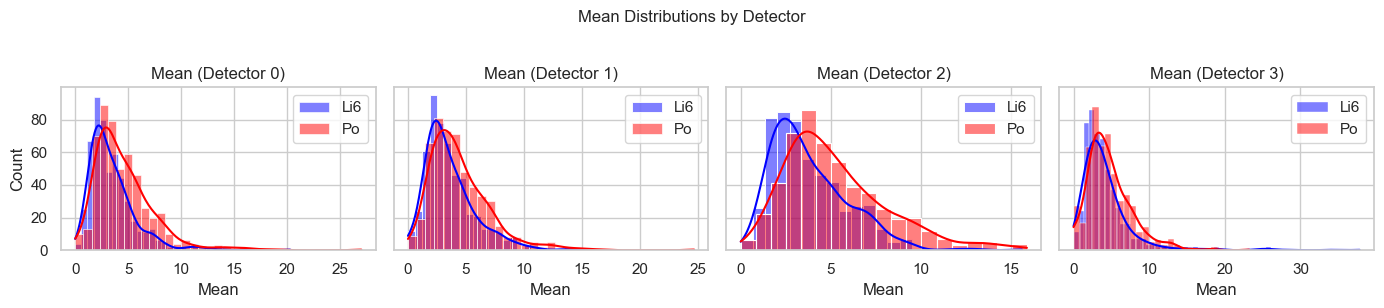

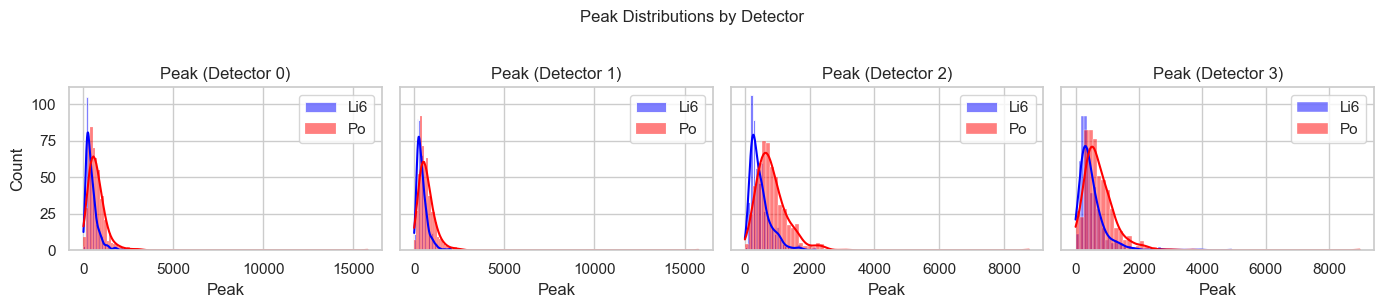

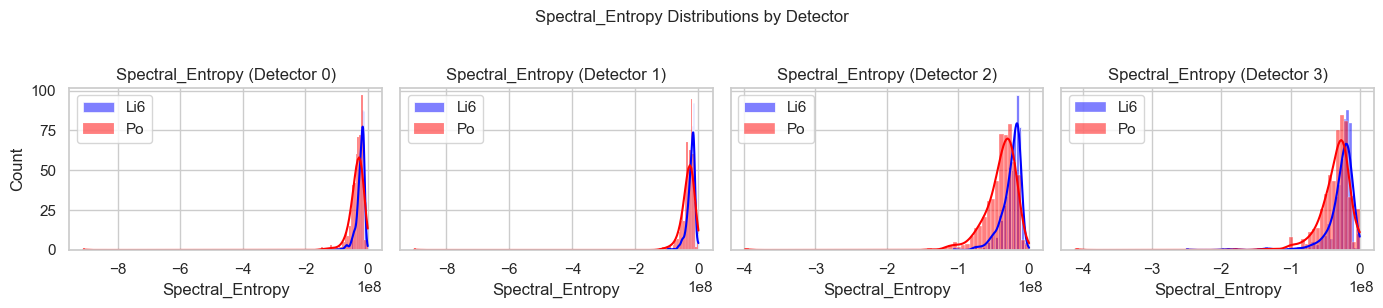

In [199]:
base_features = ["Mean", "Peak", "Dominant_Freq", "Spectral_Entropy"]

plot_features_by_base_feature(
    features_Li6=Li6_features,
    features_Po=Po_features,
    base_feature_names=base_features,
    save_path="plots/features_by_base_feature",
    show=True
)


### Detailed Pair Plot of Selected Features

Up to now, we've compared each base feature across detectors in histograms. Now, we want to **combine** a few of these features into a **single pair plot**, allowing us to see their interactions directly:
- **Mean_Ch0**: Mean amplitude on detector 0.
- **Peak_Ch1**: Maximum amplitude on detector 1.
- **Spectral_Entropy_Ch2**: Spectral entropy on detector 3
- **Mean_Ch3**: Mean amplitude on detector 4

One can play with this code to better understand the dataset

Selected Features for Pair Plot: ['Mean_Ch0', 'Peak_Ch1', 'Spectral_Entropy_Ch2', 'Mean_Ch3']
Shape of the pair-plot DataFrame: (1052, 5)
    Mean_Ch0  Peak_Ch1  Spectral_Entropy_Ch2  Mean_Ch3 Label
0   3.476562    151.00           -24736580.0  3.001953   Li6
1   4.531250   1630.00           -39662980.0  6.378906   Li6
2  11.265625    402.00           -30285872.0  4.175781   Li6
3   1.556641    314.25           -15666186.0  3.386719   Li6
4   1.251953    329.25           -17906306.0  2.390625   Li6


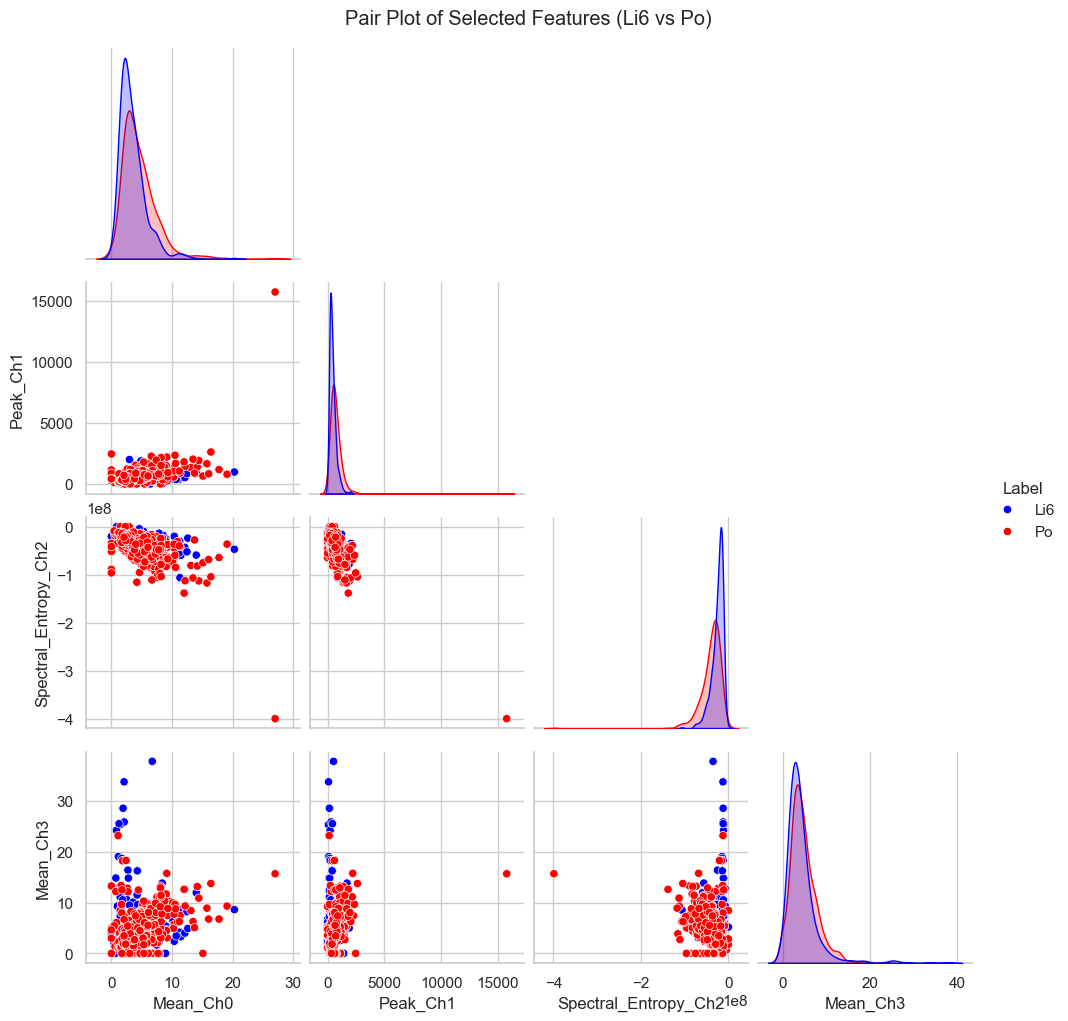

In [207]:
# -------------------------------------------------------------------
# STEP 1: Define the subset of feature columns to visualize
# -------------------------------------------------------------------
selected_features = ["Mean_Ch0", "Peak_Ch1", "Spectral_Entropy_Ch2", "Mean_Ch3"]

print(f"Selected Features for Pair Plot: {selected_features}")

# -------------------------------------------------------------------
# STEP 2: Build a DataFrame for Seaborn
# -------------------------------------------------------------------
import pandas as pd
all_selected_cols = []

# 1) Subset the columns from 'features'
#    We find indices that match our selected_features in feature_names_full.
selected_indices = []
for feat in selected_features:
    if feat in feature_names_full:
        selected_indices.append(feature_names_full.index(feat))
    else:
        print(f"Warning: feature '{feat}' not found in 'feature_names_full'.")

# 2) Create an array containing only these columns
subset_features = features[:, selected_indices]

# 3) Create a DataFrame
df_subset = pd.DataFrame(subset_features, columns=selected_features)

# 4) Add the label column
df_subset["Label"] = ["Li6" if lab == 0 else "Po" for lab in labels]

print(f"Shape of the pair-plot DataFrame: {df_subset.shape}")
print(df_subset.head())

# -------------------------------------------------------------------
# STEP 3: Generate the Pair Plot
# -------------------------------------------------------------------
import seaborn as sns

pair_plot = sns.pairplot(
    data=df_subset, 
    hue="Label",
    diag_kind="kde",
    corner=True,
    palette=["blue", "red"]
)

pair_plot.fig.suptitle("Pair Plot of Selected Features (Li6 vs Po)", y=1.02)

# Show or save
plt.show()


## 1. Building a Simple Classifier

In this section, we use basic machine learning classifiers—RandomForest, SVM, and XGBoost—to discriminate between the Li6 (label=0) and Po (label=1) waveforms using extracted features. This approach provides a **fast baseline** before moving on to more complex models.


In [211]:
from utils.ml_classifiers import create_dataset, train_and_evaluate_ml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


ModuleNotFoundError: No module named 'xgboost'

In [212]:
!pip install xgboost

     -------------------------------------- 124.9/124.9 MB 2.0 MB/s eta 0:00:00



[notice] A new release of pip available: 22.3.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### Step 1: Create the Dataset

Using our waveforms for Li6 and Po, we will extract features using either the **simple** approach or the **fusion** approach—both are available in our utilities. We’ll merge Li6 and Po data into a single `(X, y)` dataset, where `X` is the feature matrix, and `y` is the label vector (0=Li6, 1=Po).


In [ ]:
use_fusion = False  # or True if you want the 'extract_features_fusion' approach

X, y = create_dataset(
    Li6_data=Li6_waveforms,
    Po_data=Po_waveforms,
    fusion=use_fusion
)

print("Dataset shapes:")
print("X:", X.shape, "  y:", y.shape)
print("First row of X:", X[0])
print("First label:", y[0])


     ---------------------------------------- 11.1/11.1 MB 3.9 MB/s eta 0:00:00
     -------------------------------------- 301.8/301.8 kB 3.7 MB/s eta 0:00:00



[notice] A new release of pip available: 22.3.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### Step 2: Train-Test Split

We split off a portion (e.g., 20%) of the data for testing. A fixed random seed ensures reproducibility.
In addition, we normalize the data as many classifiers (especially SVM, XGBoost) may benefit from standardizing features so that each dimension has mean=0 and std=1. We apply a `StandardScaler` to ensure uniform scale across different feature dimensions.



In [ ]:
# CELL 3: Train-Test Split
# ------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=42
)
print(f"Train set size: {X_train.shape}, Test set size: {X_test.shape}")
